In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/tmp/ipykernel_22018/3777615979.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
sys.path.append("../libraries/")
from data_loading import *
from data_extracting import *

In [3]:
from qat.qpus import get_default_qpu
linalg_qpu = get_default_qpu()

## 2. Loading Data

Typically, when we want to load some data into the quantum circuit, we will want to load a discrete probability distribution $p_d$ and an array $f$. First thing we need to define the dimension of the circuit and what we want to load. Here $n$ is the number of qubits and $N = 2^n$ is the size of the discretized probability distribution and the size of the array. In this specific example $n = 3$ and $N = 8$.

In [4]:
n = 3
N = 2**n
x = np.arange(N)

Next, we define a discrete probability distribution:

$$p_d = \left(p_0,p_1,p_2,p_3,p_4,p_5,p_6,p_7\right).$$

In this specific example we are going to generate the following probability distribution:

$$p_d = \dfrac{1}{0+1+2+3+4+5+6+7}\left(0,1,2,3,4,5,6,7\right),$$
which is saved in the variable *probability*.

In [5]:
probability = x/np.sum(x)

Finally we define an array:
$$f = \left(f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7\right).$$
Later, it will become useful to have a normalised version of this function that we will call $\hat{f}$. This new function $\hat{f}$ has the main characteristic that where the maximum absolute value of the function is one $||\hat{f}||_{\infty} = 1$:
$$\hat{f} = \dfrac{f}{||f||_{\infty}} = \left(\hat{f}_0,\hat{f}_1,\hat{f}_2,\hat{f}_3,\hat{f}_4,\hat{f}_5,\hat{f}_6,\hat{f}_7\right).$$
In the code, this is the reason why we introduce the variable *normalization_constant* $=||f||_{\infty}$.

In this specific example we choose $f$ to simply be:
$$f = \left(0,1,2,3,4,5,6,7\right).$$
Hence, $\hat{f}$ is:
$$\hat{f} = \dfrac{f}{||f||_{\infty}} = \dfrac{1}{7}\left(0,1,2,3,4,5,6,7\right).$$


In [6]:
normalization_constant = np.max(x)
f = x
f_normalised = x/normalization_constant

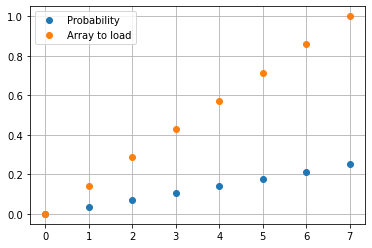

In [7]:
%matplotlib inline
plt.plot(x, probability, 'o')
plt.plot(x, f_normalised, 'o')
plt.grid()
plt.legend(['Probability', 'Array to load'])

### 1.1 Loading Probability

To load a discrete probability distribution we just need the function **load_probability**, which inside the **data_loading** module. The input should be a numpy array with the probability distribution that we want to load into the quantum state. In this case the probability distribution is the variable *probability*. The output of the function is a **qlm** *AbstractGate* with arity *n*. 

In [8]:
routine = load_probability(probability)

Now, our quantum state has the form:
$$\left[\sqrt{p_0}|0\rangle+\sqrt{p_1}|1\rangle+\sqrt{p_2}|2\rangle+\sqrt{p_3}|3\rangle+\sqrt{p_4}|4\rangle+\sqrt{p_5}|5\rangle+\sqrt{p_6}|6\rangle+\sqrt{p_7}|7\rangle\right]$$
The corresponding circuit can be visualized directly passing the qlm routine *routine* to %qatdisplay.

In [9]:
%qatdisplay routine --depth 0 --svg

Last, we use the function *get_results* from **data_extracting** to obtain the probabilities loaded into the quantum circuit. By the quantum properties, what we are measuring is:


$$\left(\sqrt{p_0}^2,\sqrt{p_1}^2,\sqrt{p_2}^2,\sqrt{p_3}^2,\sqrt{p_4}^2,\sqrt{p_5}^2,\sqrt{p_6}^2,\sqrt{p_7}^2\right) = \left(p_0,p_1,p_2,p_3,p_4,p_5,p_6,p_7\right)$$

In [10]:
results,_,_,_ = get_results(routine, linalg_qpu=linalg_qpu)
quantum_probabilities = results["Probability"].values
print("Quantum probabilities: ",quantum_probabilities)
print("Classical probabilities: ",probability)
#Test
np.isclose(quantum_probabilities, probability).all()

Quantum probabilities:  [1.92592994e-34 3.57142857e-02 7.14285714e-02 1.07142857e-01
 1.42857143e-01 1.78571429e-01 2.14285714e-01 2.50000000e-01]
Classical probabilities:  [0.         0.03571429 0.07142857 0.10714286 0.14285714 0.17857143
 0.21428571 0.25      ]


True

In order to work properly, the function *load_probabilities* has to be the first gate of the whole circuit.

### 1.2 Loading Function

To load an array we need more steps than in the previous example. We first need to load a probability distribution in the state and reserve an extra qubit for loading the function. Here we don't want to focus on the part of loading a probability distribution as it has been already treated in the previous subsection, for that reason we will simply call the function *uniform_distribution*.

In [11]:
routine = QRoutine()
register = routine.new_wires(n+1)
routine.apply(uniform_distribution(n),register[:n])

Our circuit has the form:

In [12]:
%qatdisplay routine --depth 1 --svg

And the state now loaded in the circuit is:
$$\dfrac{1}{\sqrt{N}}|0\rangle\left[|0\rangle+|1\rangle+|2\rangle+|3\rangle+|4\rangle+|5\rangle+|6\rangle+|7\rangle\right]$$
The next step is loading our array.  For that we have the function *load_array*, this function takes as first argument a normalised array, one which has norm infinity equal or less than $1$. It admits a second argument called *method*. By default this second argument it is set to *multiplexors*, but it can also have the value *brute_force*. This second option is much less efficient in terms of quantum gates.

In [13]:
routine.apply(load_array(f_normalised),register)


$$\dfrac{1}{\sqrt{N}}|0\rangle\left[\hat{f}_0|0\rangle+\hat{f}_1|1\rangle+\hat{f}_2|2\rangle+\hat{f}_3|3\rangle+\hat{f}_4|4\rangle+\hat{f}_5|5\rangle+\hat{f}_6|6\rangle+\hat{f}_7|7\rangle\right]+...$$
The associated circuit is:

In [14]:
%qatdisplay routine --depth 0 --svg

Finally, we measure the probabilities that we have loaded.

In [15]:
results,_,_,_ = get_results(routine, linalg_qpu=linalg_qpu)
quantum_probabilities = results["Probability"].values

By the quantum properties, the result stored in the variable *quantum_probabilities* is the absolute value of the square of $\hat{f}$ divided by $N$, that is:
$$p = \dfrac{1}{N}\left(\hat{f}_0^2,\hat{f}_1^2,\hat{f}_2^2,\hat{f}_3^2,\hat{f}_4^2,\hat{f}_5^2,\hat{f}_6^2,\hat{f}_7^2,...\right)$$
There is more information stored in the variable, but we don't need it.

If we want to recover the function $f$ we need to compute the square root of the probabilities and multiplicate by $N$ and by the normalization constant:
$$f_i = N||f||_{\infty}\sqrt{p_i}$$

In [16]:
quantum_f = np.sqrt(quantum_probabilities)*np.sqrt(N)*normalization_constant
print("Array loaded in the quantum state: ",quantum_f[:N])
print("Original array: ",f)
#Test
np.isclose(quantum_f[:N], f).all()

Array loaded in the quantum state:  [5.49532361e-16 1.00000000e+00 2.00000000e+00 3.00000000e+00
 4.00000000e+00 5.00000000e+00 6.00000000e+00 7.00000000e+00]
Original array:  [0 1 2 3 4 5 6 7]


True

### 2.3 Loading a function upon a non trivial probability distribution

Now we are going to load a discrete probability distribution $p_d$ and an array $f$ altogether. This case is a combination of the two previous cases. First we start by loading the discrete probability distribution $p_d$. Note that, for loading the normalised array $\hat{f}$ we need an extra qubit. The probability function is loaded just in the first three registers: 


In [17]:
routine = QRoutine()
register = routine.new_wires(n+1)
routine.apply(load_probability(probability),register[:n])
%qatdisplay routine --depth 0 --svg

Now our quantum state is:
$$|0\rangle\left[\sqrt{p_0}|0\rangle+\sqrt{p_1}|1\rangle+\sqrt{p_2}|2\rangle+\sqrt{p_3}|3\rangle+\sqrt{p_4}|4\rangle+\sqrt{p_5}|5\rangle+\sqrt{p_6}|6\rangle+\sqrt{p_7}|7\rangle\right]$$

Next we compute the angles and load the function. Instead of loading $\hat{f}$ we are going to load $\sqrt{\hat{f}}$ to have everything in the same pace.

In [18]:
f_root = np.sqrt(f_normalised)
routine.apply(load_array(f_root),register)
%qatdisplay routine --depth 0 --svg

Now our quantum state is:
$$|0\rangle\left[\sqrt{p_0\hat{f}_0}|0\rangle+\sqrt{p_1\hat{f}_1}|1\rangle+\sqrt{p_2\hat{f}_2}|2\rangle+\sqrt{p_3\hat{f}_3}|3\rangle+\sqrt{p_4\hat{f}_4}|4\rangle+\sqrt{p_5\hat{f}_5}|5\rangle+\sqrt{p_6\hat{f}_6}|6\rangle+\sqrt{p_7\hat{f}_7}|7\rangle\right]+...$$
If we measure again, we can compare our result with the element-wise product of $p_d$ and $f$

In [19]:
results,_,_,_ = get_results(routine, linalg_qpu=linalg_qpu)
quantum_probabilities = results["Probability"].values

In [20]:
quantum_result = quantum_probabilities*normalization_constant
print("Quantum result: ",quantum_result[0:N])
print("Classical result: ",probability*f)
np.isclose(quantum_result[0:N], probability*f).all()

Quantum result:  [2.59644431e-65 3.57142857e-02 1.42857143e-01 3.21428571e-01
 5.71428571e-01 8.92857143e-01 1.28571429e+00 1.75000000e+00]
Classical result:  [0.         0.03571429 0.14285714 0.32142857 0.57142857 0.89285714
 1.28571429 1.75      ]


True

If we wanted to compute the scalar product from the previous technique, we can use a neat trick. If we just measure the last qubit (the one that is more on the left in the state or the one that is at the bottom in the circuit) we are effectively computing this amount:

In [21]:
results,_,_,_ = get_results(routine, linalg_qpu=linalg_qpu,qubits = [n])
quantum_probabilities = results["Probability"].values

In [22]:
quantum_result = quantum_probabilities*normalization_constant
print("Quantum result: ",quantum_result[0])
print("Classical result: ",np.dot(probability,f))
#Test
np.isclose(quantum_result[0], np.dot(probability,f))

Quantum result:  4.999999999999999
Classical result:  5.0


True

## 2.4 Loading two arrays

In our final example we are going to load two arrays $f$ and $g = p_d$. To load two arrays we need two extra qubits, one for the first array and another for the second one. We start again by defining our base routine with size $n+2$. As we always need to load a base distribution we load a uniform probability distribution.

In [23]:
g = probability
routine = QRoutine()
register = routine.new_wires(n+2)
routine.apply(uniform_distribution(n),register[:n])
%qatdisplay routine --depth 0 --svg

We already have defined the normalised version of $f$, $\hat{f}$ which is stored in the variable *f_normalised*. But the discrete probability distribution $p_d$ is not normalised. For this reason we define the normalised version as:
$$\hat{g} = \dfrac{g}{||g||_{\infty}}.$$

In [24]:
g_normalised = g/np.max(g)

Now we have to load the normalised arrays in the circuit. Because we have two arrays instead of one, we are going to load the first array in the first reserved register and the second one in the second reserved register.

In [25]:
routine.apply(load_array(f_normalised,id_name= '1'),register[0:n],register[n])
routine.apply(load_array(g_normalised,id_name= '2'),register[0:n],register[n+1])
%qatdisplay routine --depth 0 --svg

Now our quantum state is:
$$\dfrac{1}{\sqrt{N}}|0\rangle|0\rangle\left[f_0 g_0|0\rangle+f_1 g_1|1\rangle+f_2 g_2|2\rangle+f_3 g_3|3\rangle+f_4 g_4|4\rangle+f_5 g_5|5\rangle+f_6 g_6|6\rangle+f_7 g_7|7\rangle\right]+...$$
If we measure again, we can compare our result with the element-wise product of $g$ and $f$

In [26]:
results,_,_,_ = get_results(routine, linalg_qpu=linalg_qpu)
quantum_probabilities = results["Probability"].values

In [27]:
quantum_result = np.sqrt(quantum_probabilities*N)*np.max(f)*np.max(g)
classical_result = f*g
print("Quantum result: ",quantum_result[:N])
print("Classical result: ",classical_result)
np.isclose(quantum_result[:N], classical_result).all()

Quantum result:  [3.05051740e-32 3.57142857e-02 1.42857143e-01 3.21428571e-01
 5.71428571e-01 8.92857143e-01 1.28571429e+00 1.75000000e+00]
Classical result:  [0.         0.03571429 0.14285714 0.32142857 0.57142857 0.89285714
 1.28571429 1.75      ]


True

If we want to compute the scalar product from our state we simply need to do a Hadamard transform. The first coefficient of the Hadamard transform is the sum of input vector, in other words, our previous state:

$$\dfrac{1}{\sqrt{N}}|0\rangle|0\rangle\left[f_0 g_0|0\rangle+f_1 g_1|1\rangle+f_2 g_2|2\rangle+f_3 g_3|3\rangle+f_4 g_4|4\rangle+f_5 g_5|5\rangle+f_6 g_6|6\rangle+f_7 g_7|7\rangle\right]+...,$$
transforms to:
$$\dfrac{1}{N}|0\rangle|0\rangle\left[f_0 g_0+f_1 g_1+f_2 g_2+f_3 g_3+f_4 g_4+f_5 g_5+f_6 g_6+f_7 g_7\right|0\rangle+...]+...$$
The rest of the coefficients depend on which specific transformation we are doing, as there are three different versions of this transform. Note that instead of a factor $\dfrac{1}{\sqrt{N}}$ now we have a factor $\dfrac{1}{N}$.

In [28]:
routine.apply(uniform_distribution(n),register[:n])
%qatdisplay routine --depth 0 --svg

In [29]:
results,_,_,_ = get_results(routine, linalg_qpu=linalg_qpu)
quantum_probabilities = results["Probability"].values

In [30]:
quantum_result = np.sqrt(quantum_probabilities)*N*np.max(f)*np.max(g)
classical_result = np.dot(f,g)
print("Quantum result: ",quantum_result[0])
print("Classical result: ",classical_result)
#Test
np.isclose(quantum_result[0], classical_result)

Quantum result:  4.999999999999997
Classical result:  5.0


True

## 2.4 Ordering conventions

Here we are following the ordering convention $|q_n...q_1q_0\rangle$ with $q_0$ being the least significant qubit. However in plain QLM they follow the oposite convention where $|q_0q_1...q_n\rangle$. Here we show how to use our functions to follow the QLM convention, indeed it is not difficult.

First, for loading a distribution we just need to apply the loading gate in opposite order:

In [31]:
routine = QRoutine()
register = routine.new_wires(n)
routine.apply(load_probability(probability),register[::-1])
%qatdisplay routine --depth 1 --svg

To get the results we do the same as always.

In [32]:
results,_,_,_ = get_results(routine, linalg_qpu=linalg_qpu)

Now we use the QLM ordering to get the probabilities:

In [33]:
quantum_probabilities = results.sort_values("Int")["Probability"].values
print("Quantum probabilities: ",quantum_probabilities)
print("Classical probabilities: ",probability)
np.isclose(quantum_probabilities, probability).all()

Quantum probabilities:  [1.92592994e-34 3.57142857e-02 7.14285714e-02 1.07142857e-01
 1.42857143e-01 1.78571429e-01 2.14285714e-01 2.50000000e-01]
Classical probabilities:  [0.         0.03571429 0.07142857 0.10714286 0.14285714 0.17857143
 0.21428571 0.25      ]


True

If we have to deal with the loading of functions it can be a little bit more tricky:

In [34]:
routine = QRoutine()
register = routine.new_wires(n+1)
control = register[:n]
target = register[n]
routine.apply(uniform_distribution(n),register[:n])
routine.apply(load_array(f_normalised),[control[::-1],target])
%qatdisplay routine --depth 0 --svg

To retrieve the results it is less convenient as now the result it is not in order 

In [35]:
results,_,_,_ = get_results(routine, linalg_qpu=linalg_qpu)
results.sort_values("Int",inplace = True)
results["Function"] = np.sqrt(results["Probability"]*N)*normalization_constant
results

,Probability,States,Amplitude,Int,Int_lsb,Function
0,7.703720e-34,|0000>,-2.775558e-17+0.000000e+00j,0,0,5.495324e-16
1,1.250000e-01,|0001>,3.535534e-01+0.000000e+00j,1,8,7.000000e+00
2,2.551020e-03,|0010>,5.050763e-02+0.000000e+00j,2,4,1.000000e+00
3,1.224490e-01,|0011>,3.499271e-01+0.000000e+00j,3,12,6.928203e+00
4,1.020408e-02,|0100>,1.010153e-01+0.000000e+00j,4,2,2.000000e+00
5,1.147959e-01,|0101>,3.388155e-01+0.000000e+00j,5,10,6.708204e+00
6,2.295918e-02,|0110>,1.515229e-01+0.000000e+00j,6,6,3.000000e+00
7,1.020408e-01,|0111>,3.194383e-01+0.000000e+00j,7,14,6.324555e+00
8,4.081633e-02,|1000>,2.020305e-01+0.000000e+00j,8,1,4.000000e+00
9,8.418367e-02,|1001>,2.901442e-01+0.000000e+00j,9,9,5.744563e+00


See that now the information is stored in all qubits marked with a zero in the rightmost qubit. That provoques that the information is stored only in the odd positions.
Another possibility is applying everything in reverse:

In [36]:
routine = QRoutine()
register = routine.new_wires(n+1)
control = register[1:n+1]
target = register[0]
routine.apply(uniform_distribution(n),register[1:n+1])
routine.apply(load_array(f_normalised),[control[::-1],target])
%qatdisplay routine --depth 0 --svg

In [37]:
results,_,_,_ = get_results(routine, linalg_qpu=linalg_qpu)
results.sort_values("Int",inplace = True)
results["Function"] = np.sqrt(results["Probability"]*N)*normalization_constant
results

,Probability,States,Amplitude,Int,Int_lsb,Function
0,7.703720e-34,|0000>,-2.775558e-17+0.000000e+00j,0,0,5.495324e-16
1,2.551020e-03,|0001>,5.050763e-02+0.000000e+00j,1,8,1.000000e+00
2,1.020408e-02,|0010>,1.010153e-01+0.000000e+00j,2,4,2.000000e+00
3,2.295918e-02,|0011>,1.515229e-01+0.000000e+00j,3,12,3.000000e+00
4,4.081633e-02,|0100>,2.020305e-01+0.000000e+00j,4,2,4.000000e+00
5,6.377551e-02,|0101>,2.525381e-01+0.000000e+00j,5,10,5.000000e+00
6,9.183673e-02,|0110>,3.030458e-01+0.000000e+00j,6,6,6.000000e+00
7,1.250000e-01,|0111>,3.535534e-01+0.000000e+00j,7,14,7.000000e+00
8,1.250000e-01,|1000>,3.535534e-01+0.000000e+00j,8,1,7.000000e+00
9,1.224490e-01,|1001>,3.499271e-01+0.000000e+00j,9,9,6.928203e+00


In this case the results are naturally stored in the order of QLM. 

## Appendix 1: Loading array with angles

When we load an array, under the hood we are relly loading some angles into the quantum ciruit. In this appendix we show how to use the angles to load a properly normalised array $\hat{f}$. As always we start by loading a base discrete probability distribution.

In [38]:
routine = qlm.QRoutine()
register = routine.new_wires(n+1)
routine.apply(uniform_distribution(n),register[:n])

 If we want to load the array $\hat{f}$ using angles, we first have to compute the associated angles:
$$ \left(\theta_0,\theta_1,\theta_2,\theta_3,\theta_4,\theta_5,\theta_6,\theta_7\right)= \theta =2\arccos\left(\hat{f}\right)=\left(2\arccos\left(\hat{f}_0\right),2\arccos\left(\hat{f}_1\right),2\arccos\left(\hat{f}_2\right),2\arccos\left(\hat{f}_3\right),2\arccos\left(\hat{f}_4\right),2\arccos\left(\hat{f}_5\right),2\arccos\left(\hat{f}_6\right),2\arccos\left(\hat{f}_7\right)\right)$$
This is the reason why we need to work with the normalised version of function $f$.

In [39]:
angles = 2*np.arccos(f_normalised)

To load angles we will use the function **load_angles**, which inside the **data_loading** module. The input should be a numpy array with the angles asociated to the normalised function $\hat{f}$. In this case the probability distribution is the variable *probability*. The output of the function is a **qlm** *AbstractGate* with arity *n*.

Next, we load the angles into the quantum state. For that we have the function *load_angles*, these function admits a second argument called *method*. By default it is set to *multiplexors*, but it can also have the value *brute_force*. The second option is much less efficient in terms of quantum gates.

In [40]:
routine.apply(load_angles(angles),register)

Now, our quantum state has the form:
$$\dfrac{1}{\sqrt{N}}|0\rangle\left[\cos\left(\dfrac{\theta_0}{2}\right)|0\rangle+\cos\left(\dfrac{\theta_1}{2}\right)|1\rangle+\cos\left(\dfrac{\theta_2}{2}\right)|2\rangle+\cos\left(\dfrac{\theta_3}{2}\right)|3\rangle+\cos\left(\dfrac{\theta_4}{2}\right)|4\rangle+\cos\left(\dfrac{\theta_5}{2}\right)|5\rangle+\cos\left(\dfrac{\theta_6}{2}\right)|6\rangle+\cos\left(\dfrac{\theta_7}{2}\right)|7\rangle\right]+...,$$
substituting the value of the angles we have the state
$$\dfrac{1}{\sqrt{N}}|0\rangle\left[\hat{f}_0|0\rangle+\hat{f}_1|1\rangle+\hat{f}_2|2\rangle+\hat{f}_3|3\rangle+\hat{f}_4|4\rangle+\hat{f}_5|5\rangle+\hat{f}_6|6\rangle+\hat{f}_7|7\rangle\right]+...$$
The associated circuit is:

In [41]:
%qatdisplay routine --depth 0 --svg

In [42]:
results,_,_,_ = get_results(routine, linalg_qpu=linalg_qpu)
quantum_probabilities = results["Probability"].values

Finally, we measure the probabilities that we have loaded and see that is the same as using the function **load_array**

In [43]:
quantum_f = np.sqrt(quantum_probabilities)*np.sqrt(N)*normalization_constant
print("Array loaded in the quantum state: ",quantum_f[:N])
print("Original array: ",f)
np.isclose(quantum_f[:N], f).all()

Array loaded in the quantum state:  [5.49532361e-16 1.00000000e+00 2.00000000e+00 3.00000000e+00
 4.00000000e+00 5.00000000e+00 6.00000000e+00 7.00000000e+00]
Original array:  [0 1 2 3 4 5 6 7]


True

## Appendix 2: Quantum Multiplexors

Implementation of data loading routines using the *Lov Grover and Terry Rudolph* routines directly, using controlled rotations by state, is highly inneficient. In general the use of controlled rotations generate highly deep quantum circuits prone to errors. A more efficient approach is the use of Quantum Multiplexors.



A Quantum Multiplexor in our case is a routine that applies a quantum gate depending on a control register. To simplify things, we are intersted in Quantum Multiplexed Ry gates. Specifically a Quantum Multiplexed Ry gate applies a $Ry$ rotation to a specific qubit dependinig on a control register. 
To give an example we are going to focus in a register with four qubits, the firs three ones are the controlls and the fourth one is the target qubit:
$$
\begin{array}{l}
&|0000\rangle\longrightarrow |0\rangle|0\rangle\\
&|0001\rangle\longrightarrow |0\rangle|1\rangle\\
&|0010\rangle\longrightarrow |0\rangle|2\rangle\\
&|0011\rangle\longrightarrow |0\rangle|3\rangle\\
&|0100\rangle\longrightarrow |0\rangle|4\rangle\\
&|0101\rangle\longrightarrow |0\rangle|5\rangle\\
&|0110\rangle\longrightarrow |0\rangle|6\rangle\\
&|0111\rangle\longrightarrow |0\rangle|7\rangle\\
\end{array}
$$
A quantum Quantum Multiplexed Ry gate applies a $Ry$ gate to the target register with angles $(\theta_0,\theta_1,\theta_2,\theta_3,\theta_4,\theta_5,\theta_6,\theta_7)$. It is easier to visualize it:
$$
\begin{array}{l}
&|0\rangle|0\rangle\longrightarrow \cos(\theta_0)|0\rangle|0\rangle+\sin(\theta_0)|1\rangle|0\rangle\\
&|0\rangle|1\rangle\longrightarrow \cos(\theta_1)|0\rangle|1\rangle+\sin(\theta_1)|1\rangle|1\rangle\\
&|0\rangle|2\rangle\longrightarrow \cos(\theta_2)|0\rangle|2\rangle+\sin(\theta_2)|1\rangle|2\rangle\\
&|0\rangle|3\rangle\longrightarrow \cos(\theta_3)|0\rangle|3\rangle+\sin(\theta_3)|1\rangle|3\rangle\\
&|0\rangle|4\rangle\longrightarrow \cos(\theta_4)|0\rangle|4\rangle+\sin(\theta_4)|1\rangle|4\rangle\\
&|0\rangle|5\rangle\longrightarrow \cos(\theta_5)|0\rangle|5\rangle+\sin(\theta_5)|1\rangle|5\rangle\\
&|0\rangle|6\rangle\longrightarrow \cos(\theta_6)|0\rangle|6\rangle+\sin(\theta_6)|1\rangle|6\rangle\\
&|0\rangle|7\rangle\longrightarrow \cos(\theta_7)|0\rangle|7\rangle+\sin(\theta_7)|1\rangle|7\rangle\\
\end{array}
$$
This is the idea. Now, to implement this operator in the original aritcle they propose a recursive way. We prefer to propose a new method to do it without the need of recursion. In this way it is easier to analise the computational cost.

To do the implementation we just need to ingredients, CNOT gates and single rotations. The CNOT gates and the RY rotations have to be applied in an alternating order. See the image below.

In [44]:
m = 3
angles = np.arange(2**m)
angles = angles/np.max(angles)
routine = qlm.QRoutine()
register = routine.new_wires(m+1)
routine.apply(load_angles(angles),register)
%qatdisplay routine --depth 0 --svg


See that the CNOT gates have always as target the target register. The controlls simply have $2^i$ periodicity with a certain $i$ depending on the position. In simpler words, the first CNOT (in the image above the one controlling in $q_2$, in the image below it controls) is in the positions $(0,2,4,6...)$. The second one is going to be in positions $(1+0,1+4,1+8,...)$. In the image below we can see a more extense example:

In [45]:
m = 4
angles = np.arange(2**m)
angles = angles/np.max(angles)
routine = qlm.QRoutine()
register = routine.new_wires(m+1)
routine.apply(load_angles(angles),register)
%qatdisplay routine --depth 0 --svg

Finally, the angles for the rotations are the Hadamard transform in sequency order of the angles that we want to load. For the circuit above it is possible to check it using the fast walsh hadamard transform:

In [46]:
fwht(angles)/2**m

array([ 5.00000000e-01, -2.66666667e-01,  0.00000000e+00, -1.33333333e-01,
        0.00000000e+00,  0.00000000e+00, -1.38777878e-17, -6.66666667e-02,
        8.67361738e-19,  8.67361738e-19,  8.67361738e-19,  8.67361738e-19,
       -3.46944695e-18, -3.46944695e-18, -3.46944695e-18, -3.33333333e-02])